## 输入库

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time

from scipy.interpolate import lagrange
from scipy.special import roots_sh_legendre

import os
import shutil

## 功能函数

### 傅里叶变换

In [5]:
def f2fk(f,NumK):
  NumX = f.shape[0]
  fk_ex = np.fft.ifft(f, axis=0)
  fk = np.conj(fk_ex[:NumK,:])
  return fk

def fk2f(fk,NumX):
  NumK,NumV = fk.shape
  fk_ex = np.zeros((NumX,NumV), dtype=complex)
  fk_ex[:NumK,:] = fk*NumX
  fk_ex[-1:-NumK:-1,:] = np.conj((fk[1:NumK,:])*NumX)
  f = np.real(np.fft.ifft(fk_ex, axis=0))
  return f

### 2D 拉格朗日插值

In [6]:
def LBF(Node):
  N = Node.shape[0]
  LBFpoly = [np.poly1d([1]) for _ in range(N)]
  for i in range(N):
    for j in range(N):
      if i != j:
        LBFpoly[i] *= Li_unit_poly(Node[i],Node[j])
  return LBFpoly


def Li_unit_poly(x0,x1):
  return np.poly1d([1/(x0-x1),x1/(x1-x0)])


def LagF(Xpolys,Ypolys,xyRange,zNode,x,y):
  xMin,yMin,xLen,yLen = xyRange
  x0 = (x-xMin)/xLen
  y0 = (y-yMin)/yLen
  xVals = np.array([poly(x0) for poly in Xpolys])
  yVals = np.array([poly(y0) for poly in Ypolys])
  re = 0.0
  for i in range(0,xVals.shape[0]):
    for j in range(0,yVals.shape[0]):
      re += xVals[i]*yVals[j]*zNode[i,j]
  return re

### 格式

In [7]:
def Scheming(Schemer,*args):
  def warpper(*args):
    return Schemer(*args)
  return warpper


@Scheming
def REC_WENO(U,bc,Limiter):
  Nb = U.shape[0] + 1
  UL = np.zeros((Nb))
  UR = np.zeros((Nb))

  if bc == 'Periodic':
    UE = np.concatenate((U[-3:],U,U[:3]))
  else:
    ones = np.ones((3))
    UE = np.concatenate((U[0]*ones,U,U[-1:]*ones))

  for j in range(0, Nb):
    UL[j] = Limiting(Limiter)(UE[j:j+5])
    UR[j] = Limiting(Limiter)(UE[j+5:j:-1])

  return UL,UR


@Scheming
def MUSCL(UA,boundary,Limiter):
  if boundary == 'Periodic':
    UAE = np.concatenate(([UA[-1]],UA,[UA[0]]))
  else:
    UAE = np.concatenate(([UA[0]],UA,[UA[-1]]))

  DU = UAE[1:] - 1.0*UAE[:-1]
  UL = UA + 0.5*DU[1:]*Limiting(Limiter)(DU[:-1],DU[1:])
  UR = UA - 0.5*DU[:-1]*Limiting(Limiter)(DU[1:],DU[:-1])

  if boundary == 'Periodic':
    UL = np.concatenate(([UL[-1]],UL))
    UR = np.concatenate((UR,[UR[0]]))
  else:
    UL = np.concatenate(([UL[0]],UL))
    UR = np.concatenate((UR,[UR[-1]]))

  return UL,UR

### 限制器

In [8]:
def Limiting(Limiter,*args):
  def warpper(*args):
    return Limiter(*args)
  return warpper


@Limiting
def VanLeer(r1,r2):
  sign = (r1*r2) > 0
  isZ = (r2 == 0)
  r2 = r2 + isZ * 1e-10  # 避免除以零错误，添加一个极小正值
  r = r1 / r2 * np.where(sign, 1.0, 0.0)
  return (np.abs(r)+r)/(np.abs(r)+1)


@Limiting
def Minmod(r1,r2):
  sign = (r1*r2) > 0
  isZ = (r2 == 0)
  r2 = r2 + isZ * 1e-10  # 避免除以零错误，添加一个极小正值
  r = r1 / r2 * np.where(sign, 1.0, 0.0)
  return np.where(r < 1.0, r, 0.0)


@Limiting
def WENO5_FD(S):
  eps = 1e-10
  V3 = ( 3.0*S[2] +  6.0*S[3] -  1.0*S[4])*0.125
  V2 = (-1.0*S[1] +  6.0*S[2] +  3.0*S[3])*0.125
  V1 = ( 3.0*S[0] - 10.0*S[1] + 15.0*S[2])*0.125
  B3 = 13.0/12.0*(S[2]-2.0*S[3]+S[4])**2+0.25*(3.0*S[2]-4.0*S[3]+S[4])**2
  B2 = 13.0/12.0*(S[1]-2.0*S[2]+S[3])**2+0.25*(S[1]-1.0*S[3])**2
  B1 = 13.0/12.0*(S[0]-2.0*S[1]+S[2])**2+0.25*(3.0*S[2]-4.0*S[1]+S[0])**2
  A3 = 0.3/(B3**2+eps)
  A2 = 0.6/(B2**2+eps)
  A1 = 0.1/(B1**2+eps)
  return (A1*V1+A2*V2+A3*V3)/(A1+A2+A3)


@Limiting
def WENO5_FV(S):
  eps = 1e-10
  h = 1.0/6.0
  V3 = ( 2.0*S[2] + 5.0*S[3] -  1.0*S[4])*h
  V2 = (-1.0*S[1] + 5.0*S[2] +  2.0*S[3])*h
  V1 = ( 2.0*S[0] - 7.0*S[1] + 11.0*S[2])*h
  B3 = 13.0/12.0*(S[2]-2.0*S[3]+S[4])**2+0.25*(3.0*S[2]-4.0*S[3]+S[4])**2
  B2 = 13.0/12.0*(S[1]-2.0*S[2]+S[3])**2+0.25*(S[1]-1.0*S[3])**2
  B1 = 13.0/12.0*(S[0]-2.0*S[1]+S[2])**2+0.25*(3.0*S[2]-4.0*S[1]+S[0])**2
  A3 = 0.3/(B3**2+eps)
  A2 = 0.6/(B2**2+eps)
  A1 = 0.1/(B1**2+eps)
  return (A1*V1+A2*V2+A3*V3)/(A1+A2+A3)

### 通量

In [9]:
def Fluxing(Fluxer,*args):
  def warpper(*args):
    return Fluxer(*args)
  return warpper


@Fluxing
def Burgers(UL,UR,a):
  return 0.25*(UL**2+UR**2+np.abs(UL+UR)*(UL-UR))


@Fluxing
def Advection(UL,UR,a):
  return (a>0)*a*UL + (a<0)*a*UR

### 场方程

In [10]:
def Field(dfk,e,k,dv,eps):
  dNek = np.sum(dfk,axis=1).reshape(-1,1)*dv
  phik = np.where( k < 0.1*k[1,0],
    0.0,
    e*dNek/(eps*k*k))
  return(phik)

### 诊断

In [11]:
def Diagnoses(t,phik,dfk,k0):
  with open('Output/TimeList.dat','a') as file:
    file.write(f'{t}\n')

  phi = fk2f(phik,Nx)
  #ene = 0.5*eps*np.sum(phi**2)*dx
  ene = np.sum(np.abs(phik)**2)*np.pi/k0
  with open('Output/energy.dat','a') as file:
    file.write(f'{ene}\n')

  with open('Output/phi.dat', 'ab') as f:
    phi.tofile(f)
  with open('Output/phik.dat', 'ab') as f:
    abs(phik).tofile(f)
  with open('Output/fa.dat', 'ab') as f:
    abs(dfk[0,:]).tofile(f)

## 初始化

### 设置输入参数

In [12]:
m   =  1.0
e   = -1.0
n   =  1.0
tem =  1.0

FlagPhi0 = False
FlagPhi1 = True
FlagNL   = True

TotalTime = 200.0
dt        = 0.1
nDiag     = 500
MaxStep   = 20000

Nk   = 32
Nv   = 513
vMax = 6.0

phi0A      = 0.0
phi0Lambda = 10.0
k0         = 0.4
delta      = 0.05

In [13]:
#global_list = ['m','e','n','tem','FlagPhi0','FlagPhi1','FlagNL','TotalTime','dt','nDiag','MaxStep','']
#for var_name in global_list:
#  globals()[var_name] = globals().get(var_name,None)

### 初始化——全局信息

定义物理常数

In [14]:
m0       = 9.1094e-31       # kg
e0       = 1.6021892e-19    # C
n0       = 1.0e19           # m^-3
tem0     = 1.0              # keV
epsilon0 = 8.854187817e-12  # F/m
B0       = 1.0              # T
mp       = 1.6726485e-27    # kg

In [15]:
#global_list = ['m0','e0','n0','tem0','epsilon0','B0','mp']
#for var_name in global_list:
#  globals()[var_name] = globals().get(var_name,None)

初始化归一

In [16]:
mRef = m0
eRef = e0
nRef = n0
temRef = tem0*1000.0*e0

vRef = np.sqrt(temRef/mRef)
tRef = np.sqrt(epsilon0*mRef/(nRef*eRef*eRef))
xRef = vRef*tRef

In [17]:
#global_list = ['mRef','eRef','nRef','temRef','vRef','tRef','xRef']
#for var_name in global_list:
#  globals()[var_name] = globals().get(var_name,None)

初始化扰动

In [18]:
phi0A = phi0A*1000.0*e0/temRef
#k0 = 2.0*np.pi*xRef/phi0Lambda
#k0 = 0.4

cPhi0 = 1.0 if FlagPhi0 else 0.0
cPhi1 = 1.0 if FlagPhi1 else 0.0
FlagCor = False

em = e/m
eps = 1.0

In [19]:
#global_list = ['em','eps','cPhi0','cPhi1','FlagCor']
#for var_name in global_list:
#  globals()[var_name] = globals().get(var_name,None)

初始化网格

In [20]:
class Element:
  def __init__(self,accOrder=3):
    self.Neibours = [[None,None],[None,None]]
    self.Randge = [[0,1],[0,1]]
    self.NodeValues = np.zeros(accOrder)
    self.Flux = np.zeros((2,2))
    self.LocalMoment = np.zeros(3)

  def get_age(self):
    return self.__age

  def set_age(self, new_age):
    if isinstance(new_age, int) and new_age >= 0:
      self.__age = new_age
    else:
      raise ValueError("Age must be a non-negative integer.")

    # 定义一个显示个人信息的方法
  def display_info(self):
    print(f"Name: {self.name}, Age: {self.get_age()}")

In [ ]:
class xInterface:
  def __init__(self,Dim,Pos=[0,0]):
    self.Dimension = Dim
    self.Position = Pos
    self.Neibours = [None,None]
    self.Direction = np.sgn(Pos[1])

  def update_xDirection(self):
    if self.Dimension==1:
      self.Direction = -sgn(Ele(self.Position[0]))
    self.Neibours[0] = Neibour
    self.Neibours[1] = -Neibour

  def getFlux(self):
    Direction = np.sgn(np.sum(self.Velocity*self.NormalVector))
    self.Neibours[0] = Ele(self.Position[0])
    self.Neibours[1] = -Flux

In [197]:
#global_list = ['k','Nx','dx','x','Nv','dv','hv','v']
#for var_name in global_list:
#  globals()[var_name] = globals().get(var_name,None)

初始化$F_0$

In [198]:
F0 = np.sqrt(m/(2.0*np.pi*tem))*np.exp(-0.5*m*v**2/tem)

dvF0 = np.zeros_like(F0)
dvF0[0,0] = (F0[0,1]-F0[0,0])*hv
dvF0[0,1:-1] = (F0[0,2:]-F0[0,:-2])*0.5*hv
dvF0[0,-1] = (F0[0,-1]-F0[0,-2])*hv

In [199]:
#global_list = ['F0','dvF0']
#for var_name in global_list:
#  globals()[var_name] = globals().get(var_name,None)

初始化$\phi_0$

In [200]:
phi0k = np.zeros_like(k)
phi0k[1,0] = 0.5*phi0A
phi0 = fk2f(phi0k,Nx)

In [201]:
#global_list = ['phi0k']
#for var_name in global_list:
#  globals()[var_name] = globals().get(var_name,None)

输出$\phi_0\left(x\right)$

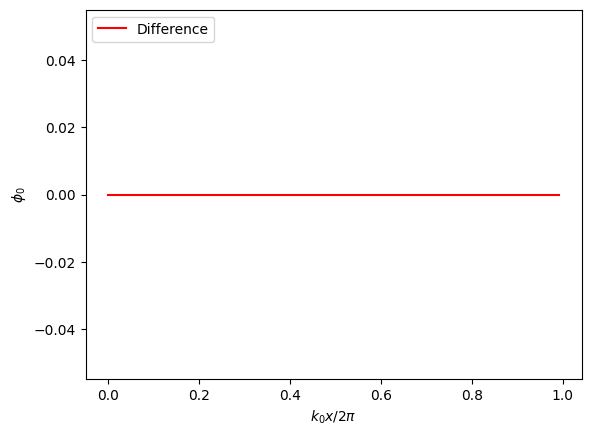

In [202]:
fig, ax1 = plt.subplots()
ax1.plot(k0*x/(2.0*np.pi),phi0,color='red',label='Difference')
ax1.set_xlabel('$k_0 x / 2\pi$',color='black')
ax1.set_ylabel('$\phi_0$',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')

### 初始化——扰动分布

初始化$\delta f_k$

In [203]:
dfk  = np.zeros((Nk,Nv))
dfk[1,:] = delta*0.5*F0
dfk0 = np.zeros_like(dfk)

phik = np.zeros_like(k)
phi = np.zeros_like(x)

### 初始化——未扰动演化信息

In [204]:
k_ex = k[:,:,np.newaxis]
v_ex = v[:,:,np.newaxis]
dtc = np.arange(1,3).reshape(1,1,2)*0.5*dt

UpdPhase = np.exp(-1j*k_ex*v_ex*dtc)

In [205]:
condition = np.abs(k_ex*v_ex) < 0.1*dv

Gkv_phik = np.where(condition,
        em*1j*k_ex*np.ones_like(v_ex)*dtc,
        em*(1.0-np.exp(-1j*k_ex*v_ex*dtc))/v_ex)
Gkx_phik = np.where(condition,
        0.5*Gkv_phik*dtc,
        Gkv_phik/(1j*k_ex*v_ex)-em*dtc*np.exp(-1j*k_ex*v_ex*dtc)/v_ex)

#del k_ex,v_ex,dtc,condition

C:\Users\73463\AppData\Local\Temp\ipykernel_2024\1572960961.py:5: RuntimeWarning: invalid value encountered in divide
  em*(1.0-np.exp(-1j*k_ex*v_ex*dtc))/v_ex)
C:\Users\73463\AppData\Local\Temp\ipykernel_2024\1572960961.py:8: RuntimeWarning: divide by zero encountered in divide
  Gkv_phik/(1j*k_ex*v_ex)-em*dtc*np.exp(-1j*k_ex*v_ex*dtc)/v_ex)
C:\Users\73463\AppData\Local\Temp\ipykernel_2024\1572960961.py:8: RuntimeWarning: invalid value encountered in divide
  Gkv_phik/(1j*k_ex*v_ex)-em*dtc*np.exp(-1j*k_ex*v_ex*dtc)/v_ex)


### 初始化——诊断

In [206]:
DiagTime = TotalTime/nDiag

output_folder = 'Output'
if os.path.exists(output_folder):
  shutil.rmtree(output_folder)
os.makedirs(output_folder)


np.savetxt('Output/Normalization.dat', 
    [mRef,eRef,tRef,vRef,xRef,k0,TotalTime,dt])

k.tofile('Output/k.bin')
x.tofile('Output/x.bin')
v.tofile('Output/v.bin')
F0.tofile('Output/F0.bin')
phi0.tofile('Output/Phi0.bin')
phi0k.tofile('Output/Phi0k.bin')

## 第0步计算

In [207]:
'时间'
t = 0.0
tStep = 0

'场方程'
phik = Field(dfk,e,k,dv,eps)
phi = fk2f(phik,Nx)

'诊断'
Diagnoses(t,phik,dfk,k0)

C:\Users\73463\AppData\Local\Temp\ipykernel_2024\4228897554.py:5: RuntimeWarning: invalid value encountered in divide
  e*dNek/(eps*k*k))


Plot输出

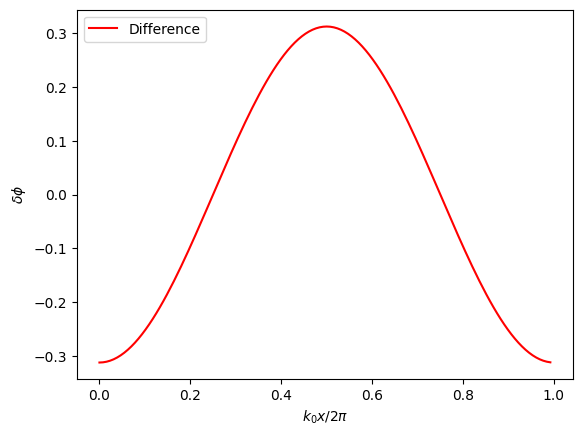

In [208]:
fig, ax1 = plt.subplots()
ax1.plot(k0*x/(2.0*np.pi),phi,color='red',label='Difference')
ax1.set_xlabel('$k_0 x / 2\pi$',color='black')
ax1.set_ylabel('$\delta\phi$',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')

## 主循环

In [209]:
NotePst = 10.0  # 5%
NoteTime = TotalTime*0.01*NotePst

STime = time.perf_counter()
while t < TotalTime-0.1*dt:
  t += dt
  tStep += 1

  'Prediction'
  if FlagNL:
    PreOrCor = 0
    dfk0 = dfk
    dfk = Upd(PreOrCor,UpdPhase,dfk0)
    dfk = PullBack(FlagNL,PreOrCor,phik,Gkx_phik,Gkv_phik,dvF0,dfk,k,hv)
    phik = Field(dfk,e,k,dv,eps)
  
  'Correction'
  PreOrCor = 1
  if not FlagNL:
    dfk0 = dfk
  dfk = Upd(PreOrCor,UpdPhase,dfk0)
  dfk = PullBack(FlagNL,PreOrCor,phik,Gkx_phik,Gkv_phik,dvF0,dfk,k,hv)
  phik = Field(dfk,e,k,dv,eps)

  if abs(round(t/DiagTime)*DiagTime-t) <= 0.1*dt:
    Diagnoses(t,phik,dfk,k0)

  if abs(round(t/NoteTime)*NoteTime-t) <= 0.1*dt:
    ETime = time.perf_counter()
    task_completion = round(t/NoteTime)*NotePst
    print(f'Task has run {task_completion}%, '
          f'this {NotePst}% is used {ETime-STime:.3f} seconds.')
    STime = ETime

C:\Users\73463\AppData\Local\Temp\ipykernel_2024\4228897554.py:5: RuntimeWarning: divide by zero encountered in divide
  e*dNek/(eps*k*k))
C:\Users\73463\AppData\Local\Temp\ipykernel_2024\4228897554.py:5: RuntimeWarning: invalid value encountered in divide
  e*dNek/(eps*k*k))


Task has run 10.0%, this 10.0% is used 9.939 seconds.
Task has run 20.0%, this 10.0% is used 7.555 seconds.
Task has run 30.0%, this 10.0% is used 7.518 seconds.
Task has run 40.0%, this 10.0% is used 7.400 seconds.
Task has run 50.0%, this 10.0% is used 7.703 seconds.
Task has run 60.0%, this 10.0% is used 7.433 seconds.
Task has run 70.0%, this 10.0% is used 7.560 seconds.
Task has run 80.0%, this 10.0% is used 7.390 seconds.
Task has run 90.0%, this 10.0% is used 7.462 seconds.
Task has run 100.0%, this 10.0% is used 7.447 seconds.


## 输出

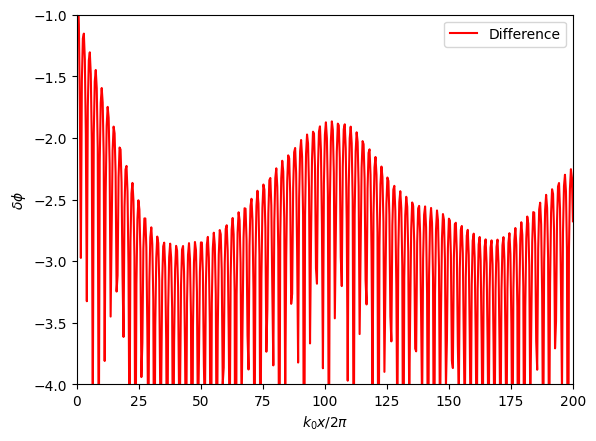

In [210]:
t = np.loadtxt('Output/TimeList.dat')
ene = np.loadtxt('Output/energy.dat')

fig, ax1 = plt.subplots()
ax1.plot(t,np.log10(ene),color='red',label='Difference')
ax1.set_xlabel('$k_0 x / 2\pi$',color='black')
ax1.set_ylabel('$\delta\phi$',color='black')
ax1.set_xlim(0, TotalTime)
ax1.set_ylim(-4, -1)
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper right')

#plt.savefig('Nonlinear.jpg', format='jpg')
#plt.show()